### Neural Networks from scratch in python - Learn handwritten numbers " MNIST database "

In [ ]:
# Tensorflow is only used to load the handwritten numbers dataset and has nothing to do with building or testing the neural network.
# matplotlib same thing. It is used only to show the first image in the dataset

In [ ]:
%pip install tensorflow
%pip install numpy
%pip install matplotlib

In [1]:
# Import necessary libraries
import tensorflow as tf  # Library for machine learning and neural networks
from tensorflow import keras  # Sub-library for building neural networks
import numpy as np  # Library for numerical computations
import matplotlib.pyplot as plt  # Library for plotting graphs and images
from Draw_Numbers import HandwritingRecognition # draw_image : This is not a library, but rather a Python file attached to this notebook in studypool.
                                                #              Place it in the same folder with this notebook and run it to be imported here.

pygame 2.5.2 (SDL 2.28.3, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Load the MNIST dataset (handwritten digits)
data = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = data.load_data()

# Normalize pixel values to 0-1 range
train_images = train_images / 255.0
test_images = test_images / 255.0

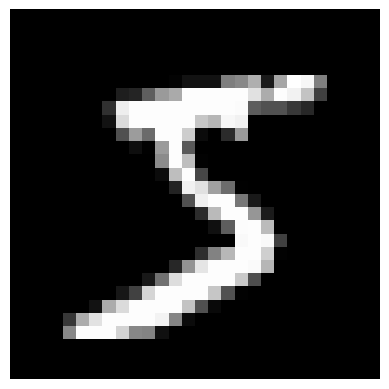

In [3]:
# Define a function to display a sample image
def generate_image(x): 
    plt.imshow(train_images[x], cmap='gray', vmin=0, vmax=1)  # Show the image
    plt.axis('off')  # Turn off the axes
    plt.show()  # Display the image

# Show the first image in the dataset
generate_image(0)

In [4]:
# Reshape the images to a 1D array (flatten)
train_images = train_images.reshape(60000, -1)
test_images = test_images.reshape(10000, -1)

In [5]:
# Print the shapes of the data

print(train_images.shape)
print(train_labels.shape)

print(test_images.shape)
print(test_labels.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [6]:
# --------------------------------------------------
# Define classes for building a neural network
# --------------------------------------------------

# Dense layer (fully connected layer)
class layer_Dense:
    def __init__(self, n_input, n_neurons):
        np.random.seed(0) # Set a random seed for reproducibility
        self.weights = 0.1 * np.random.randn(n_neurons, n_input) # Initialize weights with small random values
        self.biases = np.zeros((n_neurons, 1)) # Initialize biases to zero

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(self.weights, inputs) + self.biases  # Calculate output using matrix multiplication

    # This method is responsible for calculating the gradients (derivatives) of the loss function with respect to the weights and biases of the layer.
    def backward(self, dvalues): 
        self.dweights = np.dot(dvalues, self.inputs.T)
        self.dbiases = np.sum(dvalues, axis=1, keepdims=True)
        self.dZ = np.dot(self.weights.T, dvalues) # Calculates the error signals (dZ) to be passed back to the previous layer in the network.

    def update_weights(self, learning_rate):          # This method updates the weights and biases of the layer based on the calculated gradients
                                                      #                              and the learning rate.
        self.weights -= learning_rate * self.dweights
        self.biases -= learning_rate * self.dbiases

# Leaky ReLU activation function
class Activation_Leaky_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0.01 * inputs, inputs) # g(Z) = Z*0.01 if Z<0 / Z if Z>0

    def backward(self, dvalues):
        self.gPrim = np.where(self.inputs > 0, 1, 0.01) # g'(Z) = 0.01 if Z<0 / 1 if Z>0
        self.dvalues = dvalues * self.gPrim

# Softmax activation function
class Activation_softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=0, keepdims=True)) # Exponential e^x
        probabilities = exp_values / np.sum(exp_values, axis=0, keepdims=True) # Normlize
        self.output = probabilities
    
    # derivative of softmax
    def backward(self, dvalues, y_true):
        dvalues.T[range(len(dvalues.T)), y_true] -= 1
        self.dZ3 = dvalues

class loss:
    def calculate(self, output, labels):
        sample_losses = self.forward(output, labels) # sample_losses = negative_log
        data_loss = np.mean(sample_losses) # Calculate the average loss of all outputs          
        return data_loss                                
                                                         
class loss_All_outputs(loss): # Calculate the loss of all outputs separately         
    def forward(self, y_pred, y_true): 
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7) # 0 < y_pred < 1 
        correct_confidences = y_pred_clipped.T[range(len(y_pred.T)), y_true]
        negative_log = -np.log(correct_confidences)
        return negative_log

class Accuracy: # Calculating the accuracy of a neural network " % "
    def calculate_accuracy(self, output, labels):
        predictions = np.argmax(output, axis=0)
        accuracy = np.mean(predictions == labels)
        return accuracy

In [7]:
layer1 = layer_Dense(784, 128)  # First dense layer with 784 inputs and 128 neurons
activation1 = Activation_Leaky_ReLU()  # Leaky ReLU activation after the first layer

layer2 = layer_Dense(128, 128)  # Second dense layer with 128 neurons
activation2 = Activation_Leaky_ReLU()  # Leaky ReLU activation after the second layer

layer3 = layer_Dense(128, 10)  # Output layer with 10 neurons (one for each digit class)
activation3 = Activation_softmax()  # Softmax activation for probability distribution

loss_function = loss_All_outputs()  # Loss function (categorical cross-entropy)

Acc = Accuracy()  # Accuracy metric

In [8]:
# Hyperparameters (settings for training)
learning_rate = 0.01  # How much to adjust weights during training
batch_size = 32  # Number of images processed in each step
epochs = 10  # Number of times to loop through the entire dataset

# --------------------------------------------------
# Train the neural network using mini-batch gradient descent
# --------------------------------------------------

# Mini-Batch Gradient Descent
for epoch in range(epochs):
    for i in range(0, len(train_images), batch_size):
        batch_images = train_images[i:i + batch_size]
        batch_labels = train_labels[i:i + batch_size]

        # Forward pass
        layer1.forward(batch_images.T)
        activation1.forward(layer1.output)

        layer2.forward(activation1.output)
        activation2.forward(layer2.output)

        layer3.forward(activation2.output)
        activation3.forward(layer3.output)

        # Backpropagation
        activation3.backward(activation3.output, batch_labels) # <= dZ3
        layer3.backward(activation3.dZ3)               # W3 / B3

        activation2.backward(layer3.dZ) # <= dZ2
        layer2.backward(activation2.dvalues)           # W2 / B2

        activation1.backward(layer2.dZ) # <= dZ1
        layer1.backward(activation1.dvalues)           # W1 / B1

        # Update weights and biases
        layer1.update_weights(learning_rate)
        layer2.update_weights(learning_rate)
        layer3.update_weights(learning_rate)

    # Calculate accuracy after each training session
    layer1.forward(train_images.T)
    activation1.forward(layer1.output)

    layer2.forward(activation1.output)
    activation2.forward(layer2.output)

    layer3.forward(activation2.output)
    activation3.forward(layer3.output)

    loss = loss_function.calculate(activation3.output, train_labels)

    accuracy = Acc.calculate_accuracy(activation3.output, train_labels)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss}, Accuracy: {accuracy * 100}%")

print("Training complete!")

Epoch 1/10, Loss: 0.12168472941067646, Accuracy: 96.10666666666667%
Epoch 2/10, Loss: 0.08863813505977866, Accuracy: 97.17833333333333%
Epoch 3/10, Loss: 0.05997170799426557, Accuracy: 98.07333333333334%
Epoch 4/10, Loss: 0.11106471828355244, Accuracy: 96.56333333333333%
Epoch 5/10, Loss: 0.051351164940773845, Accuracy: 98.26833333333333%
Epoch 6/10, Loss: 0.04378385814285696, Accuracy: 98.61999999999999%
Epoch 7/10, Loss: 0.051508246453971854, Accuracy: 98.45666666666666%
Epoch 8/10, Loss: 0.045576104787855114, Accuracy: 98.5%
Epoch 9/10, Loss: 0.030020671508613955, Accuracy: 99.02833333333334%
Epoch 10/10, Loss: 0.02935192207314951, Accuracy: 99.04666666666667%
Training complete!


In [9]:
layer1.forward(test_images.T)
activation1.forward(layer1.output)

layer2.forward(activation1.output)
activation2.forward(layer2.output)

layer3.forward(activation2.output)
activation3.forward(layer3.output)

# ------------------------------------
# Evaluate performance on the test
# ------------------------------------

test_loss = loss_function.calculate(activation3.output, test_labels)

test_acc = Acc.calculate_accuracy(activation3.output, test_labels)

print(f"Loss: {test_loss}, Accuracy: {test_acc * 100}%")

Loss: 0.10596625953065728, Accuracy: 97.52%


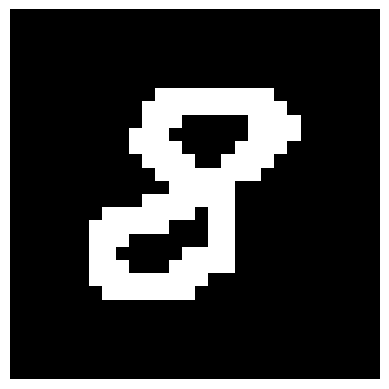

8
[[2.85590827e-06 2.46914458e-07 4.08576760e-05 4.54212212e-06
  1.29603526e-08 2.25726490e-08 6.42835852e-09 5.79778331e-07
  9.99944245e-01 6.63090471e-06]]


In [22]:
# --------------------------------
# Neural network testing
# --------------------------------

handwriting_recognition = HandwritingRecognition() 

handwriting_recognition.draw()

matrix_test = handwriting_recognition.image_matrix / 255.0

plt.imshow(matrix_test, cmap='gray', vmin=0, vmax=1)
plt.axis('off')  
plt.show()

matrix_test = matrix_test.reshape(-1, 1)

layer1.forward(matrix_test)
activation1.forward(layer1.output)

layer2.forward(activation1.output)
activation2.forward(layer2.output)

layer3.forward(activation2.output)
activation3.forward(layer3.output)

print(np.argmax(activation3.output))

print(activation3.output.T)